# <center> Analyse fréquentielle 

### 1. Préparation du dataset pour l'analyse fréquentielle

##### a. Import du dataset 

On choisit d'utiliser le dataset avec les transformations pertinentes appliquées après exploration des données. Notamment 4 styles avec un nombre insuffisant d'image ont été supprimés pour avoir des classes équilibrées lors de l'apprentissage dans la partie Deep Learning.

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent
sys.path.append(str(PROJECT_ROOT))
DATA_ROOT = PROJECT_ROOT / "data"

import src.dataset as dataset_module
import src.preprocessing as preprocessing_module

df_test, df_train, df_val = dataset_module.load_df_train_test_val(DATA_ROOT)
df_full = dataset_module.load_df(DATA_ROOT)

print(df_full.shape, df_train.shape, df_val.shape, df_test.shape)

df, df_train, df_val, df_test = preprocessing_module.clean_dataset(
    df_full, df_train, df_val, df_test
)


(9938, 8) (6956, 8) (1491, 8) (1491, 8)


##### b. Ajout des bibliothèques nécessaires

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image
import json

import src.frequency_analysis as fa_module
from importlib import reload
reload(fa_module);

##### c. On crée un échantillon représentatif 

Pour la partie 2 et 3, nous allons prendre 15 images par style pour avoir une petite base statistique sans avoir des temps de calculs trop longs.  

In [3]:
import pandas as pd
import numpy as np

# On définit le nombre d'images par style pour l'analyse
N_IMAGES_PER_STYLE = 15 

# Création de l'échantillon pour l'analyse statistique (Partie 2 et 3)
df_analysis = df_train.groupby('style_name').sample(n=N_IMAGES_PER_STYLE, random_state=6)

print(f"Échantillon d'analyse créé : {df_analysis.shape[0]} images ({N_IMAGES_PER_STYLE} images/style)")

# Test de la fonction load_image du module dataset
try:
    sample_row = df_analysis.iloc[0]
    img_test = dataset_module.load_image(sample_row, DATA_ROOT)
    print(f"Image test chargée avec succès : {sample_row['filename']} ({img_test.size})")
except Exception as e:
    print(f"Erreur lors du chargement : {e}")



Échantillon d'analyse créé : 345 images (15 images/style)
Image test chargée avec succès : 1806.jpg ((1382, 1382))


### 2. Etude de cas : Analyse Visuelle Comparative

Nous allons voir si l'analyse fréquentielle permet de montrer une différence entre deux styles : 
- contrastés (minimalisme et baroque) 
- plus ambigus (impressionnisme et Post-Impressionisme) 

##### a. Transformé de Fourier

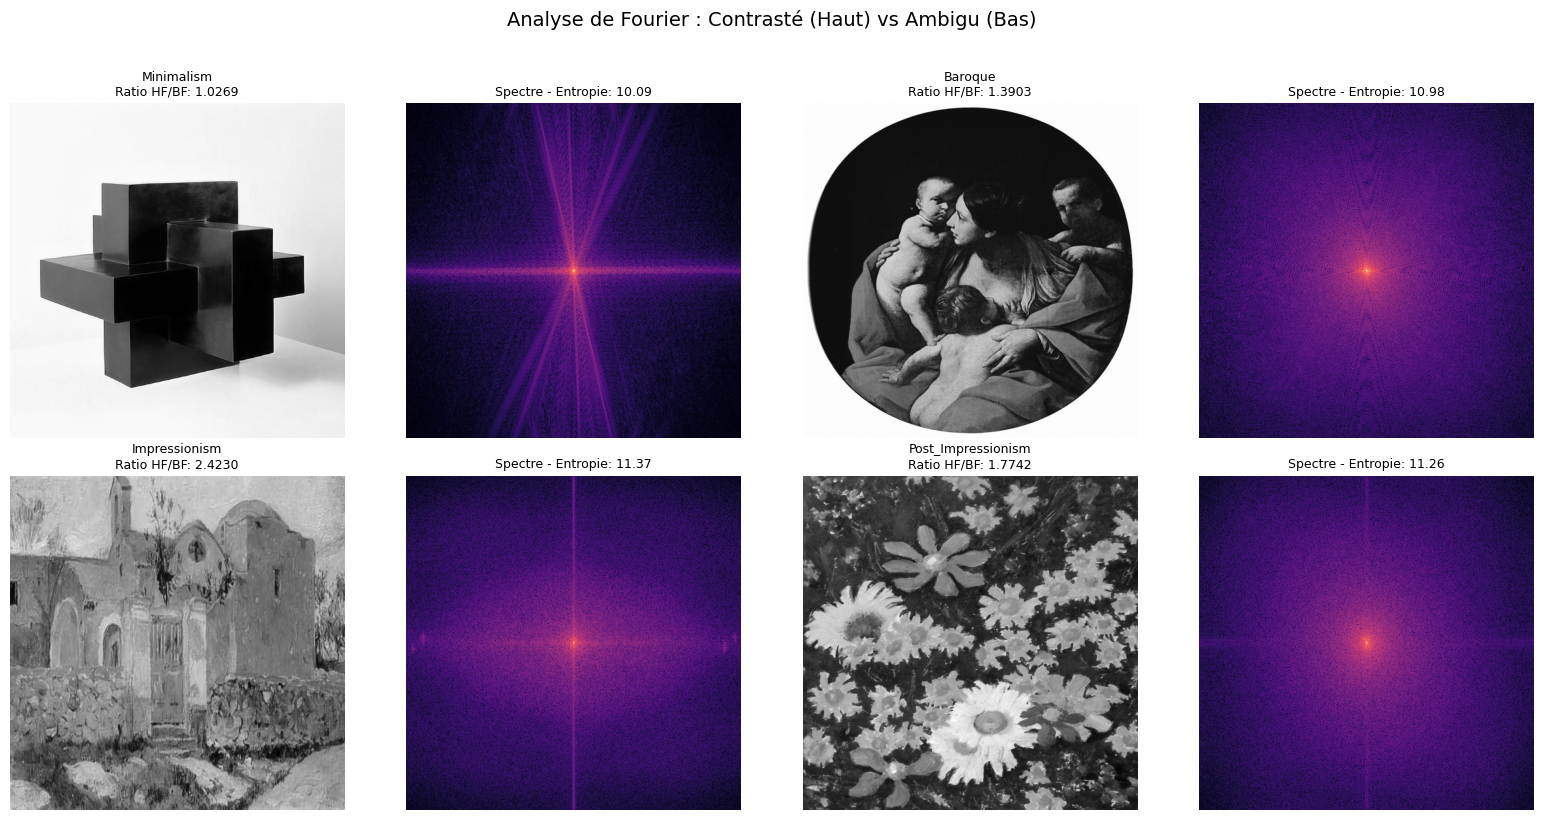

In [4]:
# Initialisation de l'analyseur
analyzer = fa_module.FrequencyAnalyzer(target_size=(512, 512))

# Sélection des styles pour nos deux cas
cases = {
    "Contrasté": ["Minimalism", "Baroque"],
    "Ambigu": ["Impressionism", "Post_Impressionism"]
}

# Configuration de la grille : 2 lignes (cas), 4 colonnes (Image + Spectre x 2)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for row_idx, (case_name, styles) in enumerate(cases.items()):
    for col_offset, style in enumerate(styles):
        #Chargement et traitement
        row = df_analysis[df_analysis['style_name'] == style].iloc[0]
        img_pil = dataset_module.load_image(row, DATA_ROOT)
        img_np = analyzer.preprocess_image(img_pil)
        f_shift, log_spec, metrics = analyzer.get_fourier_data(img_np)
        
        # Calcul de l'index de la colonne (0 et 1 pour le premier style, 2 et 3 pour le second)

        base_col = col_offset * 2

        # Affichage Image Originale
        axes[row_idx, base_col].imshow(img_np, cmap='gray')
        axes[row_idx, base_col].set_title(f"{style}\nRatio HF/BF: {metrics['hf_bf_ratio']:.4f}", fontsize=9)
        axes[row_idx, base_col].axis('off')
        
        # Affichage Spectre de Fourier
        axes[row_idx, base_col + 1].imshow(log_spec, cmap='magma')
        axes[row_idx, base_col + 1].set_title(f"Spectre - Entropie: {metrics['spectral_entropy']:.2f}", fontsize=9)
        axes[row_idx, base_col + 1].axis('off')

plt.suptitle("Analyse de Fourier : Contrasté (Haut) vs Ambigu (Bas)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Le spectre de Fourier 2D décompose l'image par fréquences : le centre contient les formes globales (basses fréquences) et la périphérie contient les détails et textures (hautes fréquences).

Interprétations :

Minimalisme (Croix, centre dense) : L'énergie est concentrée sur les structures géométriques de base. L'absence de lumière hors des croix confirme un style lisse, sans micro-textures.

Baroque (Spectre très dispersé) : La luminosité loin du centre traduit la richesse des détails, des ornements et des contrastes marqués.

Impressionnisme & Post-Impressionnisme (Dispersion et Croix visible) : Les deux styles contiennet des hautes fréquences à cause de la fragmentation des touches. La présence d'une croix centrale indique que la structure globale de la scène reste néanmoins organisée.

La similarité entre les spectres des styles Impressionnisme, Post-Impressionnisme et baroque montre que l'analyse globale de Fourier ne va très certainement pas suffir à distinguer les styles.

##### b. Filtres Passe-Haut/Passe-Bas 

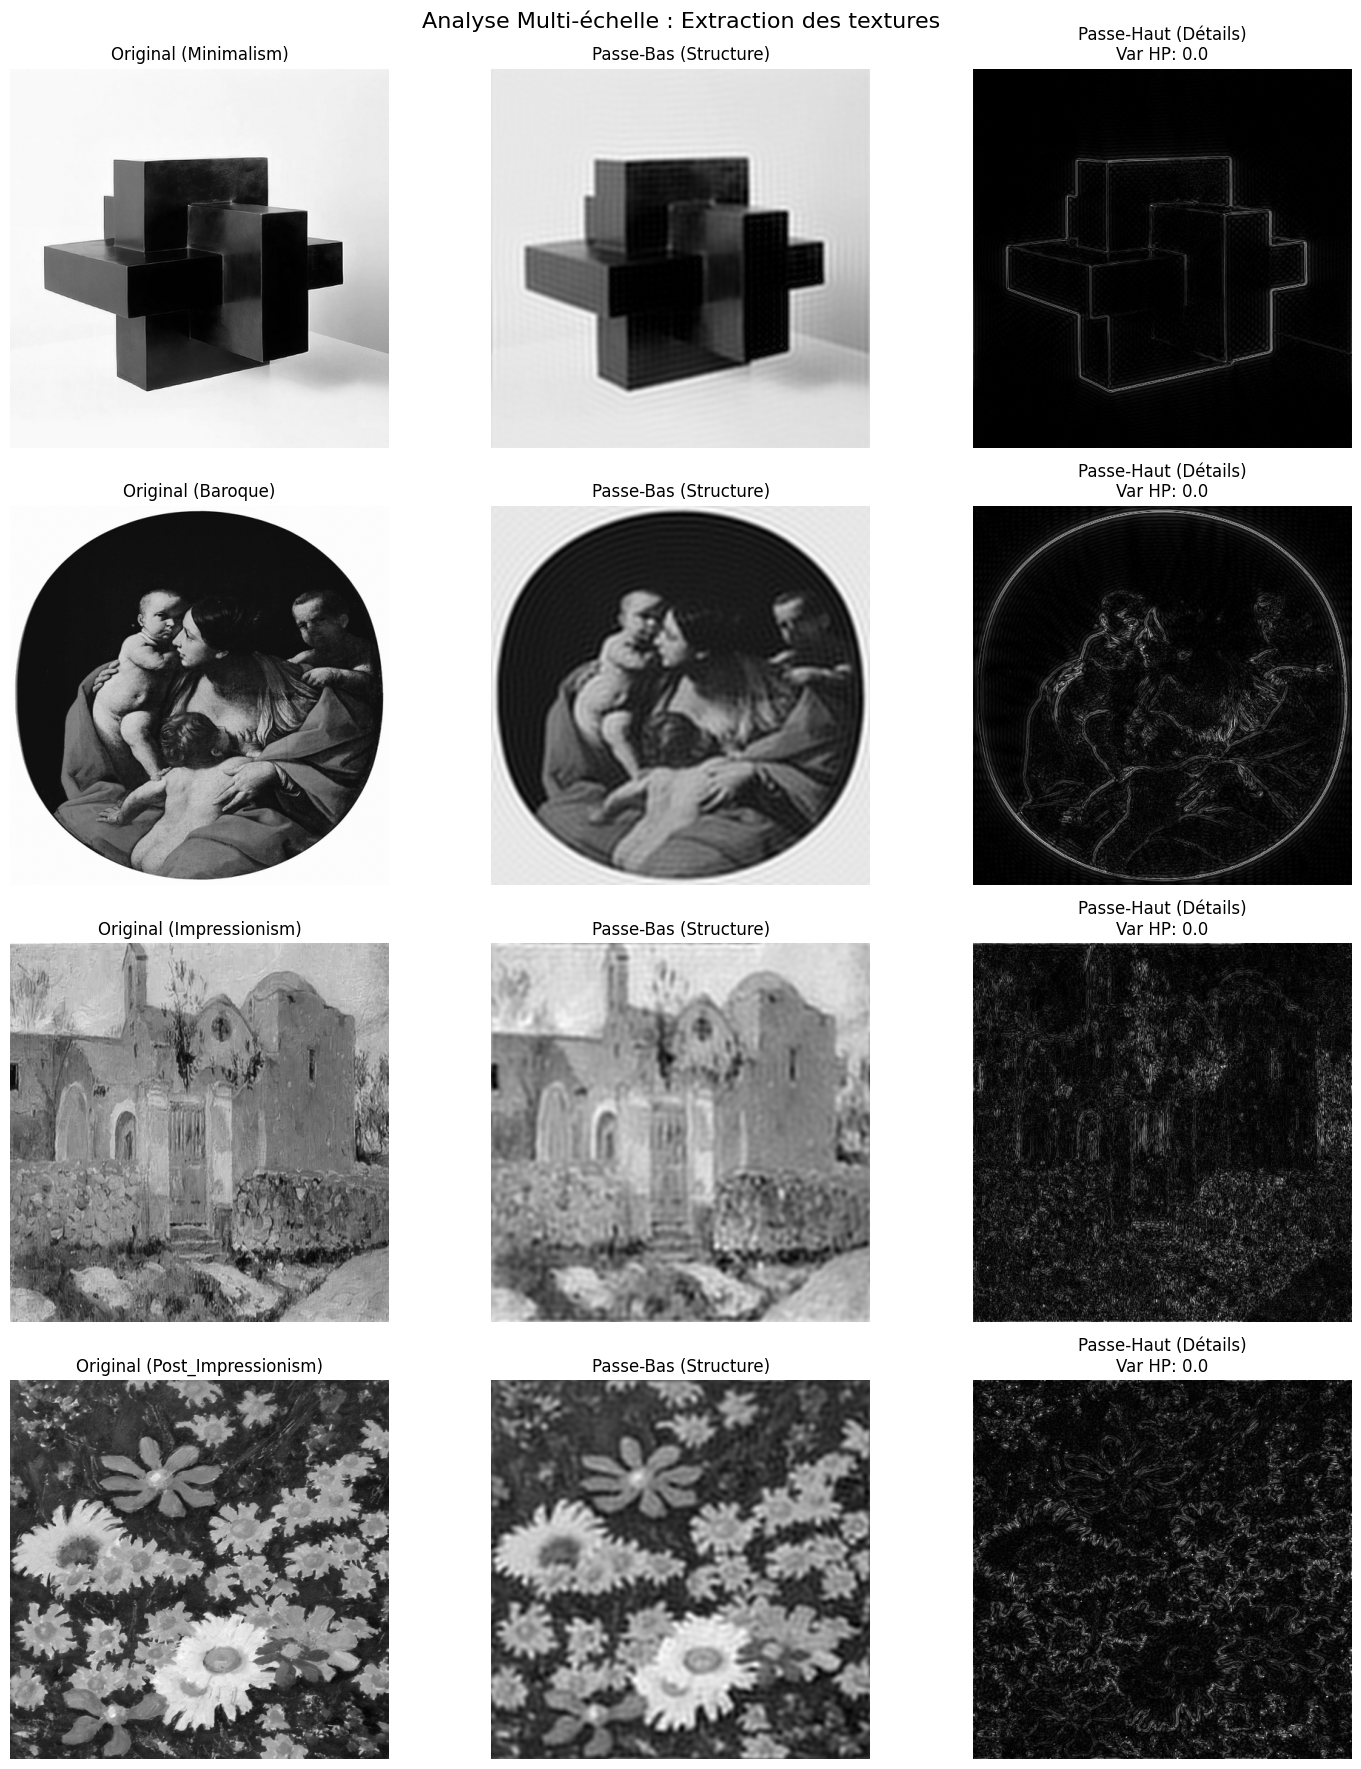

In [5]:
# Liste plate pour l'itération
all_target_styles = cases["Contrasté"] + cases["Ambigu"]

fig, axes = plt.subplots(4, 3, figsize=(15, 18))

for i, style in enumerate(all_target_styles):
    # Chargement
    row = df_analysis[df_analysis['style_name'] == style].iloc[0]
    img_pil = dataset_module.load_image(row, DATA_ROOT)
    img_np = analyzer.preprocess_image(img_pil)
    
    # Calculs
    f_shift, _, _ = analyzer.get_fourier_data(img_np)
    img_lp, img_hp, m_filt = analyzer.apply_multiscale_filters(f_shift)
    
    # Affichage
    axes[i, 0].imshow(img_np, cmap='gray'); axes[i, 0].set_title(f"Original ({style})")
    axes[i, 1].imshow(img_lp, cmap='gray'); axes[i, 1].set_title("Passe-Bas (Structure)")
    axes[i, 2].imshow(img_hp, cmap='gray'); axes[i, 2].set_title(f"Passe-Haut (Détails)\nVar HP: {m_filt['highpass_variance']:.1f}")
    
    for ax in axes[i]: ax.axis('off')

plt.suptitle("Analyse Multi-échelle : Extraction des textures", fontsize=16)
plt.tight_layout()
plt.show()

Le filtrage spatial permet d'isoler les informations de l'image selon leur taille et leur contraste. Nous utilisons ici un Filtre Passe-Bas (Low-Pass) pour extraire la structure globale et un Filtre Passe-Haut (High-Pass) pour isoler les textures fines.

Interprétations : 

Minimalisme : avec le passe bas le minimalisme conserve son essence.Avec les passe haut, peu de détails sont visibles.

Baroque, Impressionnisme et Post impressionnisme : avec le passe-bas, ces styles deviennent flous et perdent leur précision, le passe-haut au contraire révèlent les détails et la texture.

##### c. Banc de Filtres de Gabor

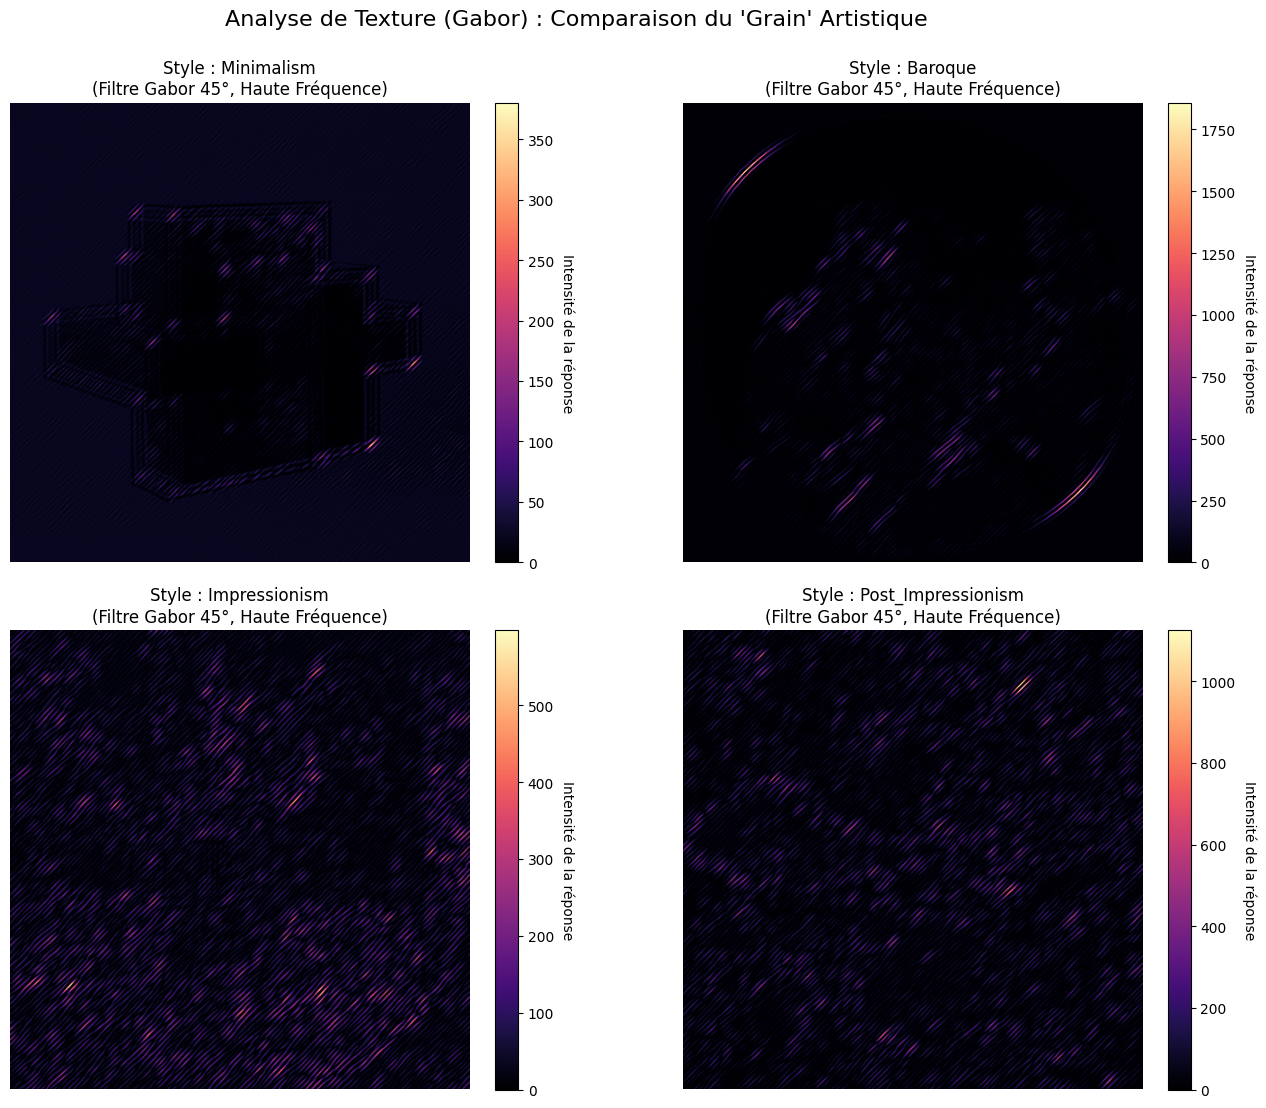

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten() 

target_filter_idx = 4 # Orientation 45°, Échelle Fine

for i, style in enumerate(all_target_styles):
    row = df_analysis[df_analysis['style_name'] == style].iloc[0]
    img_pil = dataset_module.load_image(row, DATA_ROOT)
    img_np = analyzer.preprocess_image(img_pil)
    
    responses, _ = analyzer.get_gabor_bank_features(img_np)

    # Affichage de la réponse du filtre spécifique
    im = axes[i].imshow(responses[target_filter_idx], cmap='magma', vmin=0)
    
    axes[i].set_title(f"Style : {style}\n(Filtre Gabor 45°, Haute Fréquence)", fontsize=12)
    axes[i].axis('off')
    
    cbar = plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    cbar.set_label('Intensité de la réponse', rotation=270, labelpad=15)

plt.suptitle("Analyse de Texture (Gabor) : Comparaison du 'Grain' Artistique", fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Les filtres de Gabor agissent comme des détecteurs de motifs locaux. Ils simulent la manière dont le système humain perçoit les textures et les orientations. 

Un filtre de Gabor recherche à la fois : 
- une orientation (exemple 45° ici) : le filtre réagit fortement si un trait suit cet angle précis
- une échelle/fréquence : le filtre cible soit des détils fins (grain de la toile) soit des motifs plus larges (forme d'un objet) 

Interprétation : 

Minimalisme : réponse du filtre quasi-nulle sauf au niveau des contours de l'aplat de couleur central. En effet les aplats de couleur en eux même ne contiennent aucune micro-texture directionnelle. 

Baroque : on a des réponses localisées sur les contours des formes et les drapés. 

Impressionisme et Post-Impressionisme : réponse forte et présente sur la quasi totalité des tableaux. Le filtre capture très bien les touches de peinture. 

### 3. Analyse statistique exploratoire



Pour cette phase, nous utilisons un échantillon de 15 images par style (345 images au total). 

Ce choix a été fait pour :
- la clareté : on évite de surcharger les graphiques pour pouvoir bien lire les clusters et les distributions
- la rapidité d'exécution : cela va permettre de valider nos descripteurs (Fourier, Gabor) avant de passer au dataset complet pour le SVM

In [7]:
import pandas as pd
from tqdm import tqdm

features_list = []

for i, row in tqdm(df_analysis.iterrows(), total=df_analysis.shape[0]):
    try:
        # 1. Chargement
        img_pil = dataset_module.load_image(row, DATA_ROOT)
        img_np = analyzer.preprocess_image(img_pil)
        
        # 2. Fourier
        f_shift, _, f_metrics = analyzer.get_fourier_data(img_np)
        
        # 3. Multi-échelles
        _, _, m_metrics = analyzer.apply_multiscale_filters(f_shift)
        
        # 4. Gabor
        _, g_metrics = analyzer.get_gabor_bank_features(img_np)
        
        # Fusion des résultats
        combined_features = {
            "style_name": row["style_name"],
            **f_metrics,
            **m_metrics,
            **g_metrics
        }
        features_list.append(combined_features)
        
    except Exception as e:
        print(f" Erreur sur l'image {i} ({row['style_name']}): {e}")

# Conversion finale
df_features = pd.DataFrame(features_list)
print(f"Tableau de caractéristiques créé : {df_features.shape}")

100%|██████████| 345/345 [02:23<00:00,  2.41it/s]

Tableau de caractéristiques créé : (345, 45)


##### a. Transformée de Fourier 

**Distribution du ratio HF/BF par Style :**

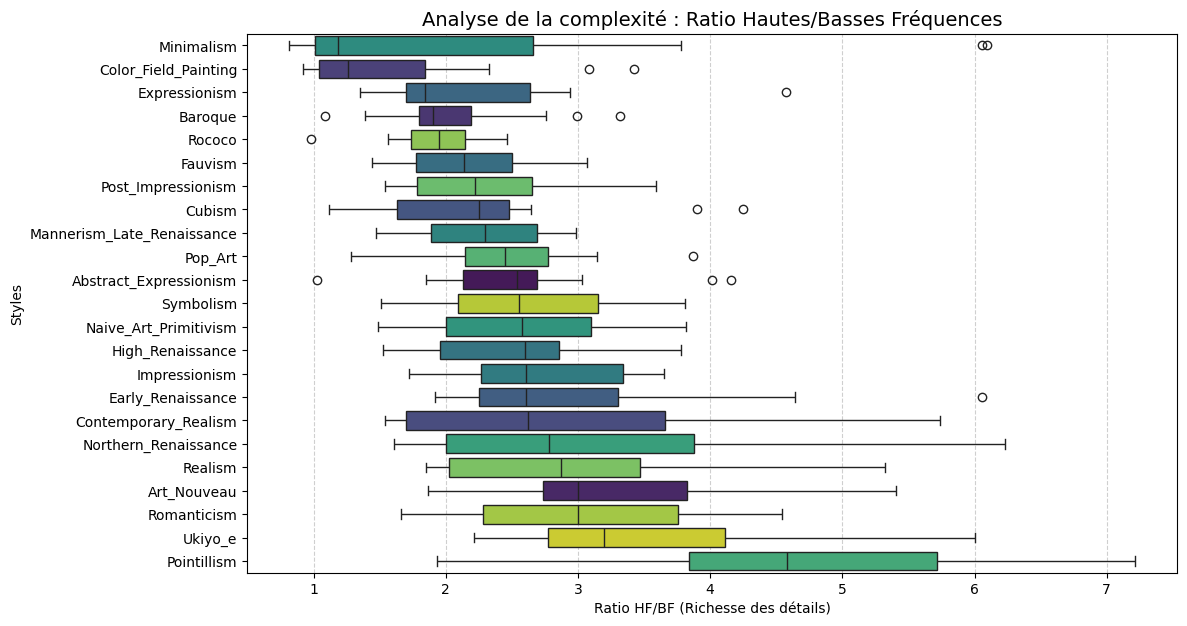

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tri des styles par ratio médian pour faciliter la lecture
order = df_features.groupby("style_name")["hf_bf_ratio"].median().sort_values().index

plt.figure(figsize=(12, 7))
sns.boxplot(data=df_features, x="hf_bf_ratio", y="style_name", order=order, hue="style_name", legend=False, palette="viridis")

plt.title("Analyse de la complexité : Ratio Hautes/Basses Fréquences", fontsize=14)
plt.xlabel("Ratio HF/BF (Richesse des détails)")
plt.ylabel("Styles")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

La médiane du box plot montre la valeur typique du style. 

Le ratio HF/BF confirme qu'il y a un lien entre complexité visuelle et courants artistiques.  
Le Minimalisme présente les ratios les plus bas (environ 1,2), traduisant une absence de détails fins au profit des formes globales.  
À l'opposé, le Pointillisme atteint les valeurs les plus hautes (environ 4,5), prouvant que l'information est concentrée dans les micro-textures.  
Entre ces deux extrêmes, les autres styles s'échelonnent, la largeur de leurs boîtes indiquant une plus ou moins grande diversité de traitement au sein d'un même mouvement.

**Profils d'énergie radiale :**

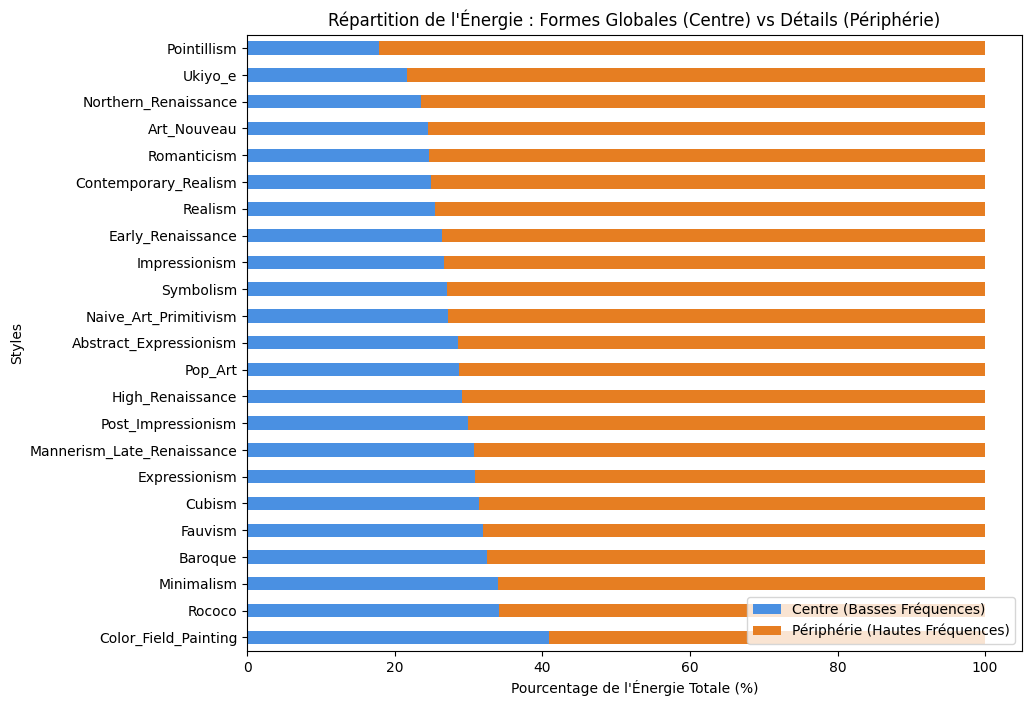

In [9]:
# Préparation des données pour un barplot comparatif
df_energy = df_features.groupby("style_name")[["energy_center", "energy_periphery"]].mean()

# On normalise pour voir la répartition relative (%)
df_energy_perc = df_energy.div(df_energy.sum(axis=1), axis=0) * 100

df_energy_perc.sort_values("energy_periphery").plot(
    kind='barh', 
    stacked=True, 
    figsize=(10, 8),
    color=['#4a90e2', '#e67e22']
)

plt.title("Répartition de l'Énergie : Formes Globales (Centre) vs Détails (Périphérie)")
plt.xlabel("Pourcentage de l'Énergie Totale (%)")
plt.ylabel("Styles")
plt.legend(["Centre (Basses Fréquences)", "Périphérie (Hautes Fréquences)"], loc='lower right')
plt.show()

Les styles avec une longues barre orange (Périphérie=haute fréquence) sont ceux qui ont le plus de micro détails. 

Ceux avec une dominance bleue sont plus épurés. 

##### b. Multi-Echelles 

**Espace énergie Passe-bas vs Passe-Haut :**

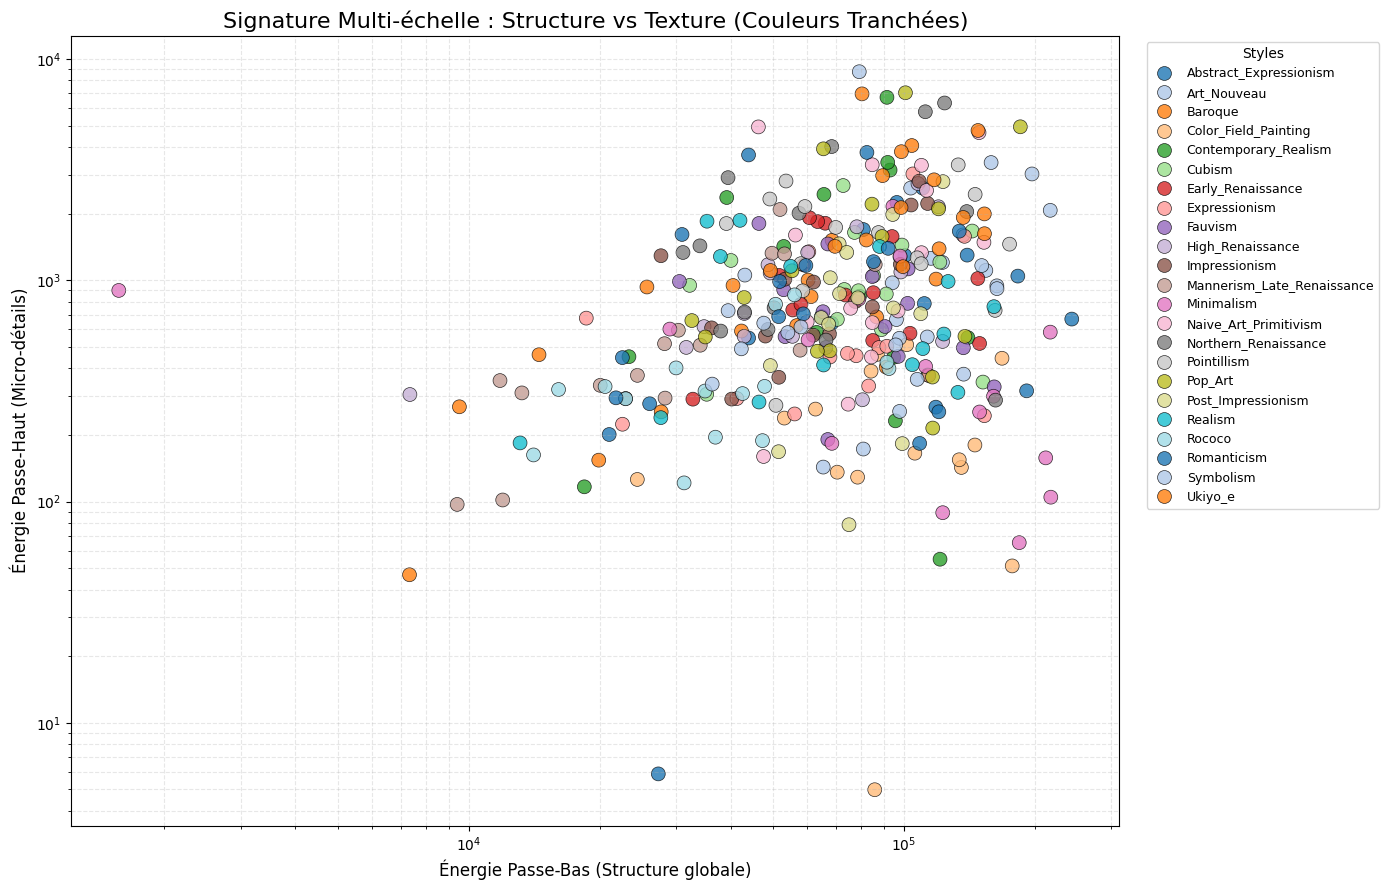

In [10]:
plt.figure(figsize=(14, 9))

sns.scatterplot(
    data=df_features, 
    x="lowpass_energy", 
    y="highpass_energy", 
    hue="style_name", 
    palette="tab20", #
    alpha=0.8,      
    edgecolor="black", 
    linewidth=0.5,
    s=100            
)

plt.xscale('log') 
plt.yscale('log')

plt.title("Signature Multi-échelle : Structure vs Texture (Couleurs Tranchées)", fontsize=16)
plt.xlabel("Énergie Passe-Bas (Structure globale)", fontsize=12)
plt.ylabel("Énergie Passe-Haut (Micro-détails)", fontsize=12)

# On place la légende à l'extérieur avec une police lisible
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="Styles", fontsize=9, ncol=1)

plt.grid(True, which="both", linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

On projette les images sur deux axes : l'intensité des structures larges ($x$) et l'intensité des détails fins ($y$). 

Normalement : 
- en haut à droite : styles complexes avec à la fois des grands contrastes et beaucoup de détails
- en bas à gauche : styles épurés, lisses


Avec nos images, nous n'arrivons pas à distinguer particulièrement des clusters. Les points sont fortement corrélés et se chevauchent massivement. Lowpass_energy et highpass_energy ne sont donc sûrment pas des bons critères pour séparer les classes. 

**Heatmap de la variance multi-échelle :**

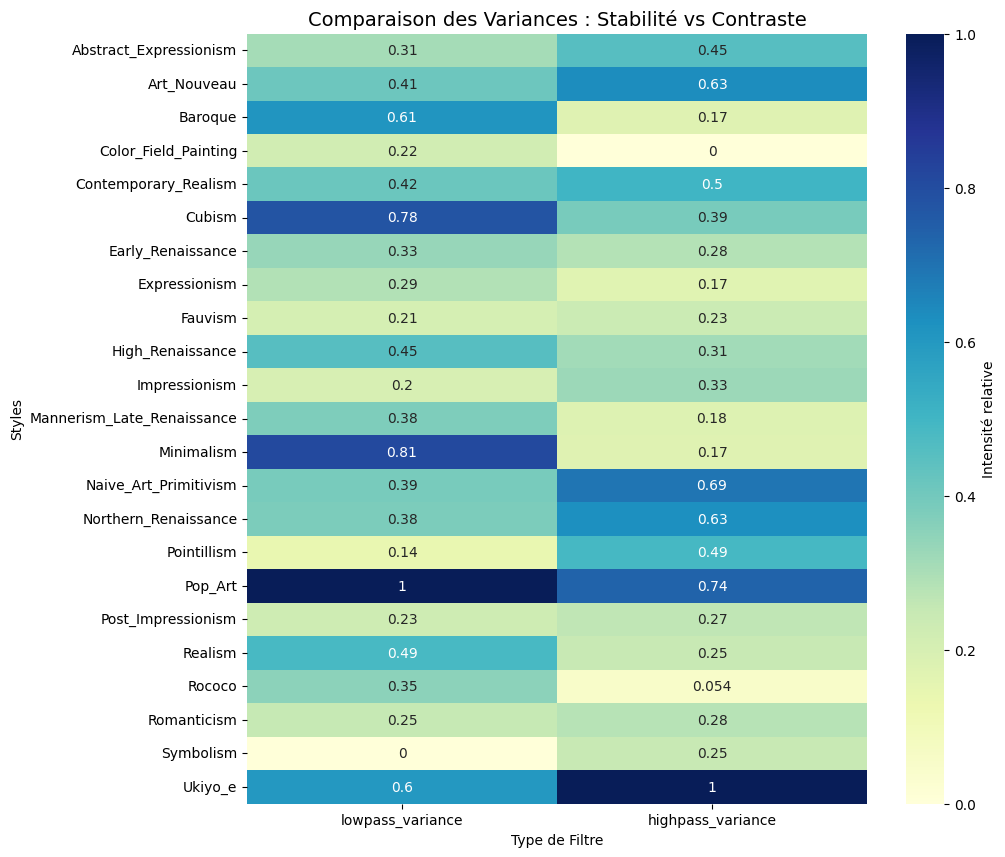

In [11]:
# Préparation des données : moyenne de la variance par style
df_var = df_features.groupby("style_name")[["lowpass_variance", "highpass_variance"]].mean()

# Normalisation par colonne pour comparer les styles entre eux (0 à 1)
df_var_norm = (df_var - df_var.min()) / (df_var.max() - df_var.min())

plt.figure(figsize=(10, 10))
sns.heatmap(df_var_norm, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Intensité relative'})

plt.title("Comparaison des Variances : Stabilité vs Contraste", fontsize=14)
plt.xlabel("Type de Filtre")
plt.ylabel("Styles")
plt.show()

La heatmap compare la variance (l'intensité du contraste) entre les structures globales (Lowpass) et les détails fins (Highpass). 

Ce que nous observons : 
- Styles à fort contraste global : Certains styles présentent des valeurs élevées sur les deux colonnes. Cela indique une dynamique visuelle forte, avec des masses de couleurs tranchées et des détails marqués.

- Styles "Lisses" ou Homogènes : D'autres styles affichent des valeurs faibles partout, signe d'une transition douce entre les couleurs et d'une absence de micro-contrastes.

- Déséquilibre : Les lignes où les deux colonnes ont des couleurs très différentes sont les plus intéressantes. Un style avec une highpass_variance élevée mais une lowpass_variance faible possède une texture vibrante et des formes très floues ou peu contrastées.

##### c. Gabor 

**Radar Chart : Directionnalité**

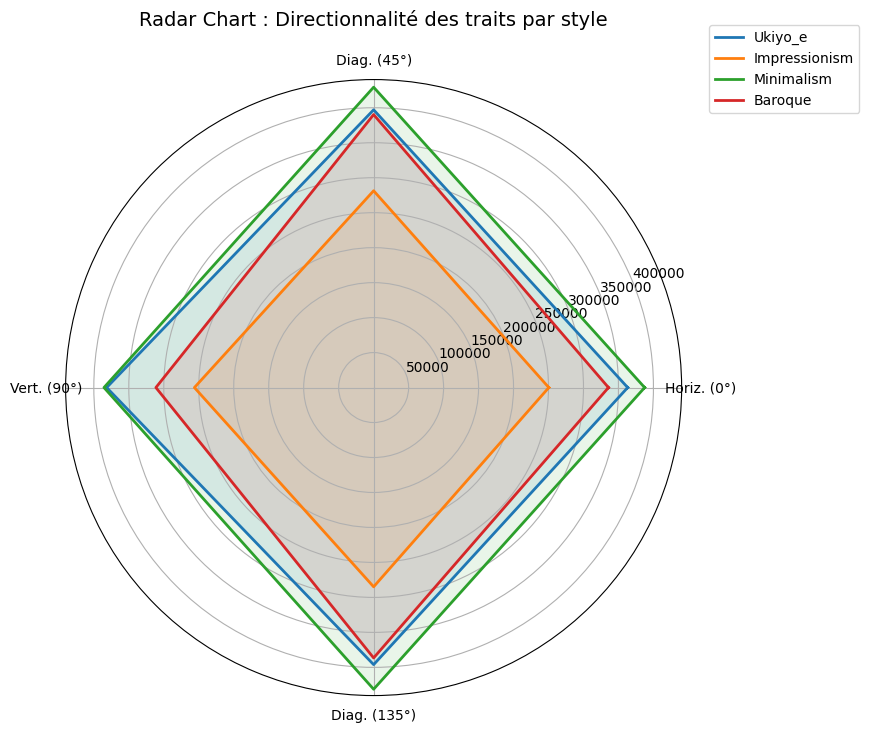

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_gabor_radar(df, styles_to_comp):
    # On définit les 4 angles extraits
    labels = ['Horiz. (0°)', 'Diag. (45°)', 'Vert. (90°)', 'Diag. (135°)']
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1] # Fermer le cercle

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for style in styles_to_comp:
        subset = df[df['style_name'] == style]
        # Moyenne des variances pour chaque angle (toutes fréquences f0, f1, f2 confondues)
        values = [
            subset[[c for c in df.columns if 'var_th0' in c]].mean().mean(),
            subset[[c for c in df.columns if 'var_th45' in c]].mean().mean(),
            subset[[c for c in df.columns if 'var_th90' in c]].mean().mean(),
            subset[[c for c in df.columns if 'var_th135' in c]].mean().mean()
        ]
        values += values[:1]
        
        ax.plot(angles, values, linewidth=2, label=style)
        ax.fill(angles, values, alpha=0.1)

    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    plt.title("Radar Chart : Directionnalité des traits par style", fontsize=14, pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

# Sélectionne 3-4 styles très différents pour voir le contraste
plot_gabor_radar(df_features, ["Ukiyo_e", "Impressionism", "Minimalism","Baroque"])

Les graphiques en radar révèlent la réponse des textures selon quatre angles (0°, 45°, 90°, 135°).

Si le Losange est parfait, cela signifie que le style est isotrope (autant de traits dans tous les sens). C'est le cas de l'Impressionnisme (losange presque parfait).

Si une pointe du losange est beaucoup plus longue que les autres, c'est là qu'on a une direction privilégiée (anisotropie). 

La taille du losange, mesure la force du contraste texturale.
Le minimalisme a un plus grand radar car il possède des contours nets et des contratses brutaux, ce qui génère une variance bien plus forte que les touches plus fondues de l'Impressionnisme. 


**Boxplot de l'entropie de Gabor :**

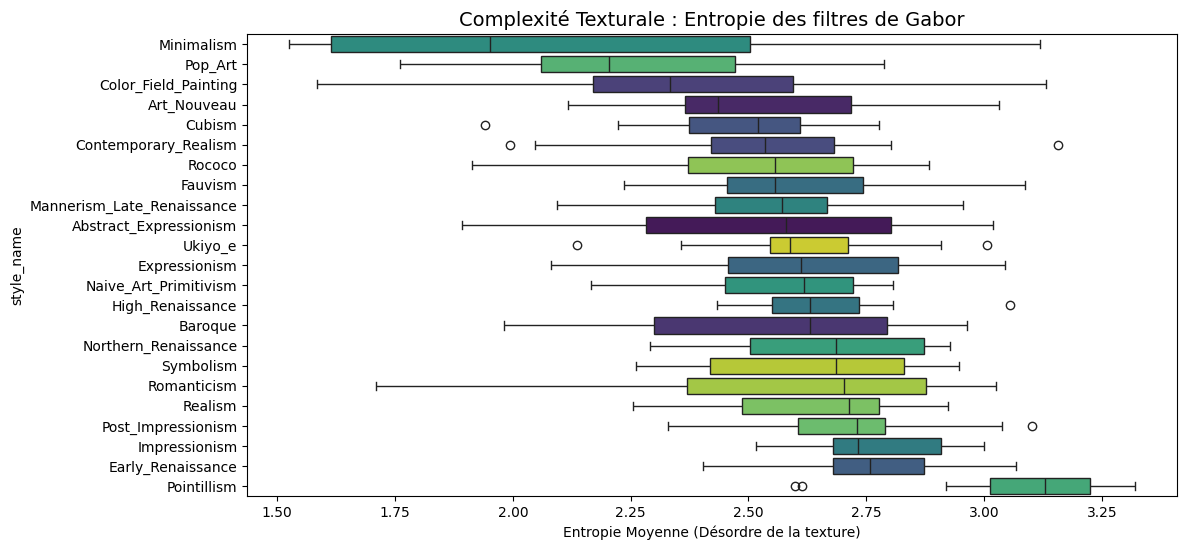

In [13]:
# On calcule l'entropie moyenne (tous angles/fréquences confondus) pour chaque image
entropy_cols = [c for c in df_features.columns if 'entropy' in c]
df_features['mean_gabor_entropy'] = df_features[entropy_cols].mean(axis=1)

plt.figure(figsize=(12, 6))
order_ent = df_features.groupby("style_name")["mean_gabor_entropy"].median().sort_values().index

sns.boxplot(data=df_features, x="mean_gabor_entropy", y="style_name", 
            order=order_ent, hue="style_name", palette="viridis", legend=False)

plt.title("Complexité Texturale : Entropie des filtres de Gabor", fontsize=14)
plt.xlabel("Entropie Moyenne (Désordre de la texture)")
plt.show()

L'entropie mesure le désordre de la texture : 
- une entropie faible montre une texture régulière répétitive. C'est le cas des styles Minimalisme, Pop Art, Color Field Painting, Art Nouveau et Cubisme.  
- une entropie élevée montre une texture cahostique, complexe (coups de pinceau très visibles). C'est le cas par exemple des styles Impressionnisme, Early Renaissance ou Pointillisme. 

##### d. PCA 

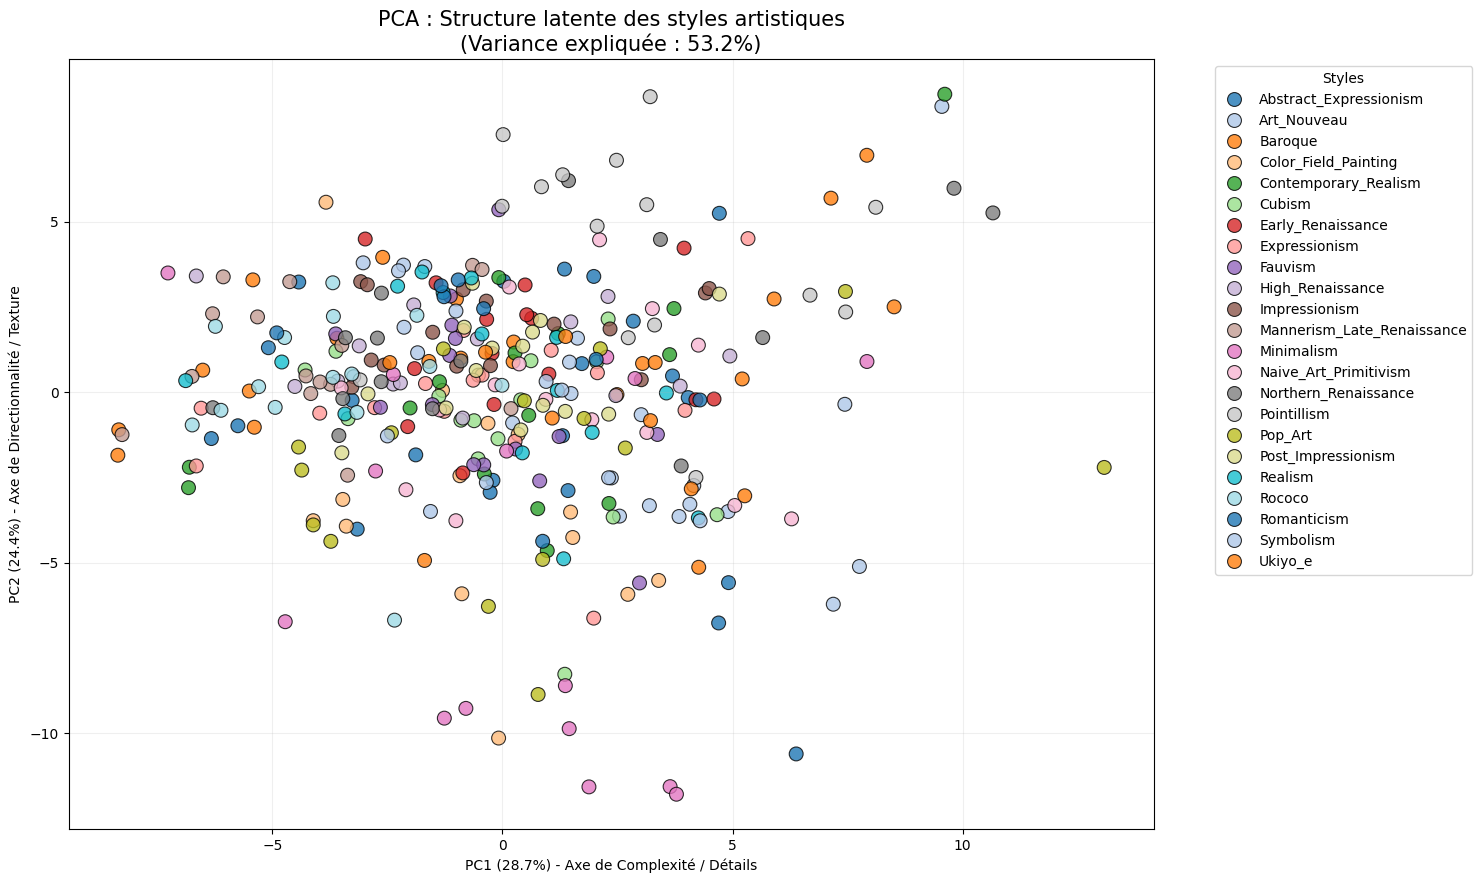

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Sélection des colonnes numériques uniquement
features_cols = [c for c in df_features.columns if c not in ['style_name', 'split']]
x = df_features[features_cols].values

# 2. Standardisation (Crucial : Fourier et Gabor n'ont pas les mêmes unités)
x_scaled = StandardScaler().fit_transform(x)

# 3. Calcul de la PCA
pca = PCA(n_components=2)
coords = pca.fit_transform(x_scaled)

# 4. Création du DataFrame pour l'affichage
df_pca = pd.DataFrame(data=coords, columns=['PC1', 'PC2'])
df_pca['style_name'] = df_features['style_name'].values

# 5. Visualisation
plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=df_pca, x='PC1', y='PC2', hue='style_name', 
    palette='tab20', s=100, alpha=0.8, edgecolor='black'
)

# On affiche le pourcentage de variance expliquée
var_exp = pca.explained_variance_ratio_ * 100
plt.title(f"PCA : Structure latente des styles artistiques\n(Variance expliquée : {var_exp.sum():.1f}%)", fontsize=15)
plt.xlabel(f"PC1 ({var_exp[0]:.1f}%) - Axe de Complexité / Détails")
plt.ylabel(f"PC2 ({var_exp[1]:.1f}%) - Axe de Directionnalité / Texture")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Styles", ncol=1)
plt.grid(True, alpha=0.2)
plt.show()

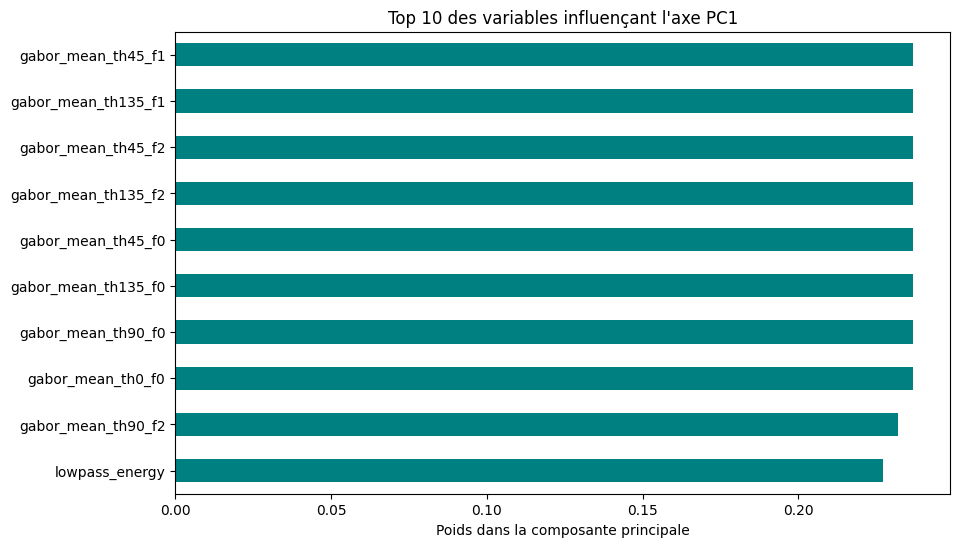

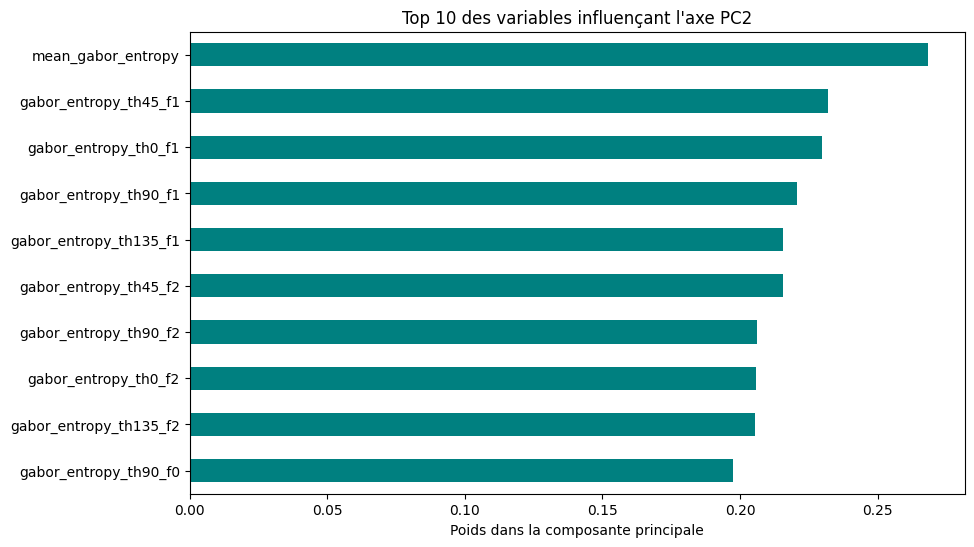

In [15]:
# Récupération des contributions (loadings)
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=['PC1', 'PC2'], 
    index=features_cols
)

# Affichage des 10 variables les plus influentes pour PC1
plt.figure(figsize=(10, 6))
loadings['PC1'].sort_values().tail(10).plot(kind='barh', color='teal')
plt.title("Top 10 des variables influençant l'axe PC1")
plt.xlabel("Poids dans la composante principale")
plt.show()

# Affichage des 10 variables les plus influentes pour PC2
plt.figure(figsize=(10, 6))
loadings['PC2'].sort_values().tail(10).plot(kind='barh', color='teal')
plt.title("Top 10 des variables influençant l'axe PC2")
plt.xlabel("Poids dans la composante principale")
plt.show()

La projection des 345 images sur les deux axes principaux (couvrant 53,2% de la variance totale) révèle une structure complexe et entremêlée.

On observe une distribution continue où les styles se chevauchent massivement. A part le Minimalisme et le Pointillisme qui sont très légèrement isolés des autres (mais éparpillés). 


On a donc de nombreux styles qui partagent des caractéristiques fréquentielles et texturales similaire. L'analyse purement mathématiques de la texture ne va certainement pas suffir à distinguer le style. Il va nous falloir compléter ces informations avec les éléments de vision classique et peut-être également le genre. 

Egalement le modèle de classification devra travailler dans un espace de haute dimension pour trouver des frontières non linéaires, car une simple séparation 2D est impossible

### 4. Pipeline d'extraction massive

In [ ]:
import os
import pandas as pd
from tqdm import tqdm

# Configuration des chemins
output_path = "results/final_frequency_features.csv"
log_path = "results/extraction_errors_frequency_features.log"

# Nettoyage des anciens fichiers 
if os.path.exists(output_path): os.remove(output_path)
if os.path.exists(log_path): os.remove(log_path)

print(f"Lancement de l'extraction. Résultats : {output_path}")

for split in ['train', 'val', 'test']:
    df_split = df_analysis[df_analysis['split'] == split]
    
    for i, row in tqdm(df_split.iterrows(), total=len(df_split), desc=f"Split {split}"):
        try:
            # Pipeline
            img_pil = dataset_module.load_image(row, DATA_ROOT)
            img_np = analyzer.preprocess_image(img_pil)
            features = analyzer.extract_features_from_image(img_np)
            
            # Métadonnées
            features['style_name'] = row['style_name']
            features['split'] = split
            features['filename'] = row['filename']
            
            # Sauvegarde itérative
            df_temp = pd.DataFrame([features])
            df_temp.to_csv(output_path, mode='a', index=False, header=not os.path.exists(output_path))
            
        except Exception as e:
            # On écrit l'erreur dans un fichier texte dédié
            with open(log_path, "a") as f:
                f.write(f"Erreur Image {i} ({row['filename']}): {str(e)}\n")

Vérification Post-Extraction :

In [ ]:
# Chargement du dataset complet
df_final = pd.read_csv("results/final_frequency_features.csv")

# 1. Vérification des volumes
print("Répartition par split :\n", df_final['split'].value_counts())

# 2. Détection des NaN (images corrompues ou division par zéro)
if df_final.isna().sum().sum() > 0:
    print(f" {df_final.isna().sum().sum()} valeurs manquantes supprimées.")
    df_final = df_final.dropna()

# 3. Filtrage des Outliers (Bruit numérique)
# Un hf_bf_ratio trop élevé indique souvent une image de très basse qualité ou parasite
initial_count = len(df_final)
df_final = df_final[df_final['hf_bf_ratio'] <= 10]
print(f" Outliers supprimés : {initial_count - len(df_final)} images.")

# 4. Sauvegarde de la version "propre"
df_final.to_csv("results/final_frequency_features_cleaned.csv", index=False)

### 5. Synthèse et exportaion

##### a. Matrice de Corrélation de Pearson

On supprime les colonnes corrélées. 

In [ ]:
plt.figure(figsize=(15, 12))
corr_matrix = df_final.drop(columns=['style_name', 'split', 'filename']).corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title("Heatmap : Corrélations entre descripteurs")
plt.show()

# Code pour identifier les features à supprimer (r > 0.95)
upper = corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(f"Colonnes redondantes à supprimer : {to_drop}")

##### b. Importance Relative

Quelles sont les 20 variables qui séparent le mieux les styles? (celles où la différence entre les moyennes des styles est la plus forte)

In [ ]:
from sklearn.feature_selection import f_classif

# Calcul du F-score
X = df_final.drop(columns=['style_name', 'split', 'filename'])
y = df_final['style_name']
f_values, _ = f_classif(X, y)

# Affichage du Top 20
sel_features = pd.Series(f_values, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sel_features.head(20).plot(kind='barh', color='darkred')
plt.title("Top 20 des Features les plus discriminantes (ANOVA F-statistic)")
plt.xlabel("Score d'importance")
plt.show()